#  Cell Counting

Cell counting is a fundamental task found in many biological research and medical diagnostic processes. It underlies decisions in cell culture, drug development, and disease analysis. However, traditional manual cell counting methods are often time-consuming and prone to human error. This variability can hinder research progress and lead to inconsistencies across studies. 

Although cell counting machines exist, they are expensive and may not be readily available to all researchers. Automating cell counting using machine learning offers a powerful solution to this problem. ML-powered cell counters can quickly and accurately analyze large volumes of cell samples, freeing up researchers' time and minimizing inconsistencies.

Ready to build your own cell counter and revolutionize your research efficiency? This tutorial equips you with the knowledge and skills to create a customized tool that streamlines your cell counting needs.


## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Cell_Counting_Tutorial.ipynb)


## Setup

To run DeepChem within Colab, you'll need to run the following installation commands. You can of course run this tutorial locally if you prefer. In that case, don't run these cells since they will download and install DeepChem in your local machine again.

In [16]:
!pip install --pre deepchem

import deepchem as dc
dc.__version__

'2.7.2.dev'

Now we will import all the necessary packages and functions

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from deepchem.data import NumpyDataset
from deepchem.models.torch_models import CNN


## BBBC Datasets

 We used the image set [BBBC002v1](https://bbbc.broadinstitute.org/bbbc/BBBC002) [[Carpenter et al., Genome Biology, 2006](http://genomebiology.com/2006/7/10/R100)] from the Broad Bioimage Benchmark Collection [[Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)] for this tutorial.

The Broad Bioimage Benchmark Collection Dataset 002 (BBBC002) contains images of Drosophila Kc167 cells. The ground truth labels consist of cell counts.
Full details about this dataset are present at https://bbbc.broadinstitute.org/BBBC002.

For counting cells, our dataset needs to have images as inputs and the corresponding cell counts as the ground truth labels. We have several BBBC datasets that can be loaded using the deepchem package. These datasets are an extension to [`MoleculeNet`](https://moleculenet.org/) and can be accessed through [`dc.molnet`](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html).


The `BBBC002` dataset consists of 60 images, each 512x512 pixels in size, which are split into train, validation and test sets in a 80/10/10 split by default. \
We also use `splitter='random'` in order to ensure that these images are randomly split into the train, validation and test sets in the above mention ratios.  

In [18]:
bbbc2_dataset = dc.molnet.load_bbbc002(splitter='random')
tasks, dataset, transforms = bbbc2_dataset
train, val, test = dataset

train_x, train_y, train_w, train_ids = train.X, train.y, train.w, train.ids
val_x, val_y, val_w, val_ids = val.X, val.y, val.w, val.ids
test_x, test_y, test_w, test_ids = test.X, test.y, test.w, test.ids


Now that we've loaded the dataset and randomly split it, let's take a look at the data.

In [19]:
print(f"Shape of train data: {train_x.shape}")
print(f"Shape of train labels: {train_y.shape}")

Shape of train data: (40, 512, 512)
Shape of train labels: (40,)


We can confirm that a sample from our dataset is in the form of a 512x512 image. Let's visualize this sample:

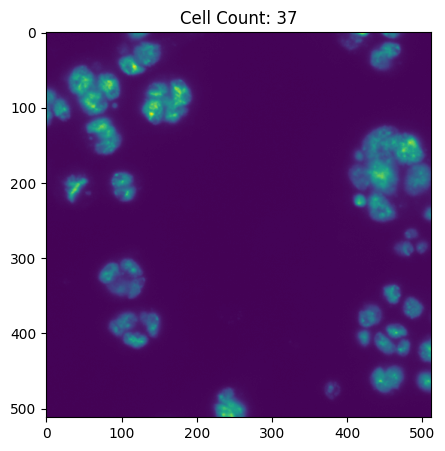

In [20]:
i = 2

plt.figure(figsize=(5, 5))
plt.imshow(train_x[i])
plt.title(f"Cell Count: {train_y[i]}")
plt.show()

Now let's prepare the data for the model.

PyTorch based CNN Models require that images be in the shape of (C, H, W), wherein 'C' is the number of input channels, 'H' is the height of the image and 'W' is the width of the image. So we will reshape the data.

In [21]:
train_x = np.array(train_x.reshape(-1, 512, 512, 1), dtype=np.float32)
train_y = np.array(train_y.reshape(-1), dtype=np.float32)

val_x = np.array(val_x.reshape(-1, 512, 512, 1), dtype=np.float32)
val_y = np.array(val_y.reshape(-1), dtype=np.float32)

test_x = np.array(test_x.reshape(-1, 512, 512, 1), dtype=np.float32)
test_y = np.array(test_y.reshape(-1), dtype=np.float32)


In [22]:
train_data = NumpyDataset(train_x, train_y)
val_data = NumpyDataset(val_x, val_y)
test_data = NumpyDataset(test_x, test_y)

## Creating and training our model

We will use the `rms_score` metric for our Validation Callback in order to monitor the performance of the model during training.

For more information on how to use callbacks, refer to this tutorial on [Advanced Model Training](https://deepchem.io/tutorials/advanced-model-training/)

We will use the CNN model from the deepchem package. Since cell counting is a relational problem, we will use the `regression` mode.

We will use a 2D CNN model, with 6 hidden layers of the following sizes [32, 64, 128, 128, 64, 32] and a kernel size of 3 across all the filters, you can modify both the kernel size and the number of filters per layer. We have also used average pooling made residual connections and added dropout layers between subsequent layers in order to improve performance. Feel free to experiment with various models.

In [28]:
regression_metric = dc.metrics.Metric(dc.metrics.rms_score)

model = CNN(n_tasks=1, n_features=1, dims=2, layer_filters = [32, 64, 128, 128, 64, 32], kernel_size=3, learning_rate=5e-4,
            mode='regression', padding='same', batch_size=4, residual=True, dropouts=0.1, pool_type='average')

callback = dc.models.ValidationCallback(val_data, 10, [regression_metric])

avg_loss = model.fit(train_data, nb_epoch=20, callbacks=callback)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Step 10 validation: rms_score=43.5554
Step 20 validation: rms_score=61.2546
Step 30 validation: rms_score=39.8772
Step 40 validation: rms_score=52.2475
Step 50 validation: rms_score=42.5802
Step 60 validation: rms_score=38.1957
Step 70 validation: rms_score=72.0341
Step 80 validation: rms_score=35.5798
Step 90 validation: rms_score=46.5774
Step 100 validation: rms_score=31.5153
Step 110 validation: rms_score=38.8215
Step 120 validation: rms_score=35.6907
Step 130 validation: rms_score=29.9797
Step 140 validation: rms_score=28.0428
Step 150 validation: rms_score=44.3926
Step 160 validation: rms_score=37.7657
Step 170 validation: rms_score=34.5076
Step 180 validation: rms_score=26.8319
Step 190 validation: rms_score=26.6618
Step 200 validation: rms_score=26.4627


## Evaluating the performance of our model

Now let's use `mean_absolute_error` as our test metric and print out the results of our model. We have also created a graph of True vs Predicted values in order to visualize our model's performance 

We can see that the model performs fairly well with a test loss of about 14.6. This means that on average, the predicted number of cells for a sample image is off by 14.6 cells when compared to the ground truth. Although this seems like a very high value for test loss, we will see that a difference of about 15 cells is actually not bad for this particular task. 

Train loss:  19.05
Val Loss:  22.2
Test Loss:  14.6


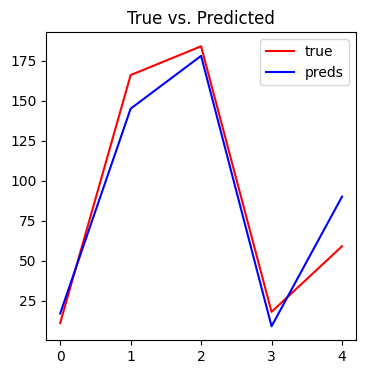

In [32]:
test_metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)

preds = np.array(model.predict(train_data), dtype=np.uint32)
print("Train loss: ", test_metric.compute_metric(train_y, preds))

preds = np.array(model.predict(val_data), dtype=np.uint32)
print("Val Loss: ", test_metric.compute_metric(val_y, preds))

preds = np.array(model.predict(test_data), dtype=np.uint32)
print("Test Loss: ", test_metric.compute_metric(test_y, preds))

plt.figure(figsize=(4, 4))
plt.title("True vs. Predicted")
plt.plot(test_y, color='red', label='true')
plt.plot(preds, color='blue', label='preds')
plt.legend()
plt.show()


Let us print out the mean cell count of our predictions and compare them with the ground truth. We will also print out the maximum difference between the ground truth and the prediction from the test set. 

In [35]:
print(f"Mean of True Values: {np.mean(test_y):.2f}")
print(f"Mean of Predictions: {np.mean(preds):.2f}")

diff = []
for i in range(len(test_y)):
  diff.append(abs(test_y[i] - preds[i]))

print(f"Max of Difference: {np.max(diff)}")

Mean of True Values: 87.60
Mean of Predictions: 87.80
Max of Difference: 31.0


We can observe that the averages of our predictions and the ground truth are very close with a difference of just 0.20. Although we see a maximum difference of 31 cells between the prediction and true value, when we take into account the `Test Loss`, the close proximity of the means of predictions and the true labels, and the small size of our test set, we can say that our model performs fairly well. 

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial

If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Bioinformatics,
 title={Cell Counting Tutorial},
 organization={DeepChem},
 author={Menezes, Aaron},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Cell_Counting_Tutorial.ipynb}},
 year={2024},
}